# Simulating the Buckley-Leverette model

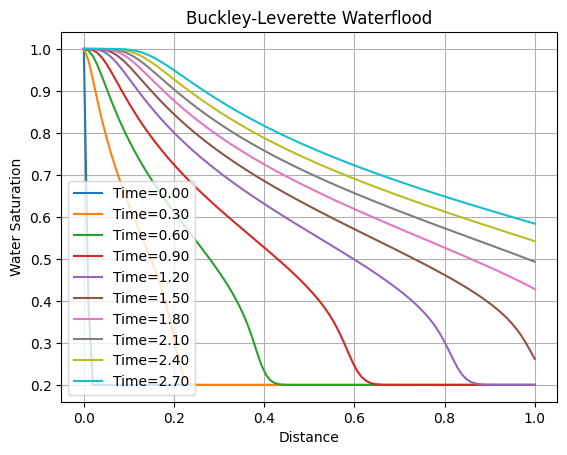

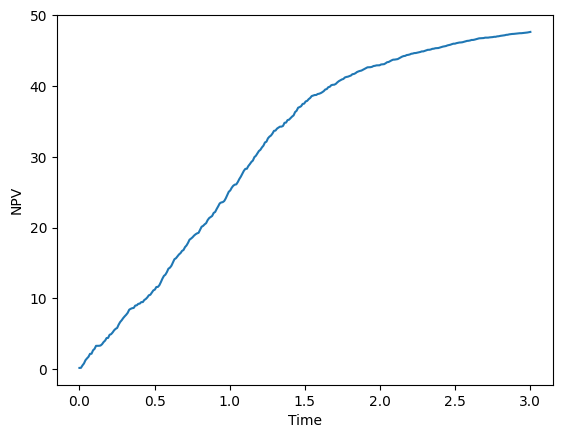

In [1]:
from buckley_leverette_ori import BuckleyLeverette 
import numpy as np

bl = BuckleyLeverette()

qt = 1.0 * np.random.rand(bl.nt)
# qt = np.ones(bl.nt) * 1.0
Sw = bl.Swinit.copy()

bl.simulate_w_plot(Sw, qt)

import matplotlib.pyplot as plt

npv = bl.cost_function(qt, Sw)

plt.plot(bl.t, npv)
plt.xlabel('Time')
plt.ylabel('NPV')
plt.show()
# bl.plot()

# Model Predictive Control for initial state x0 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



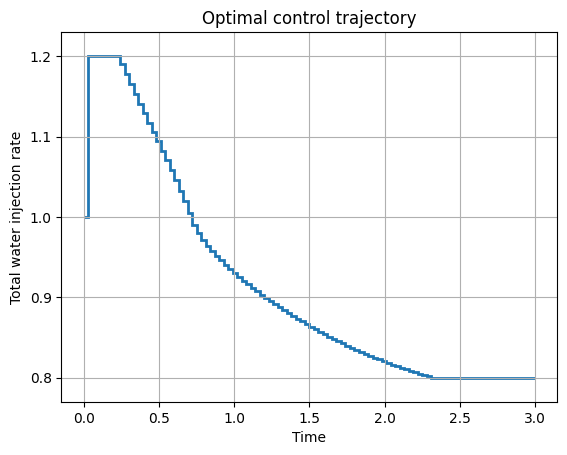

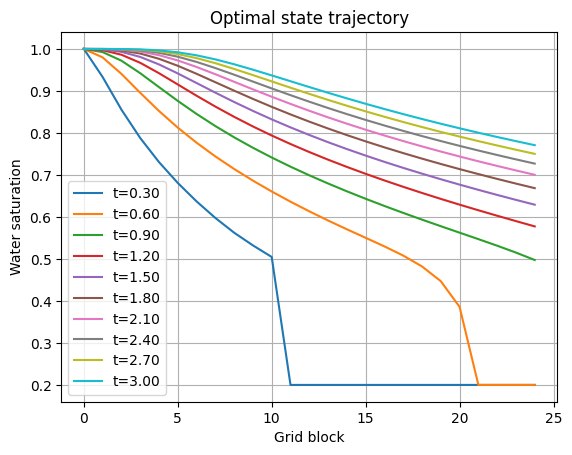

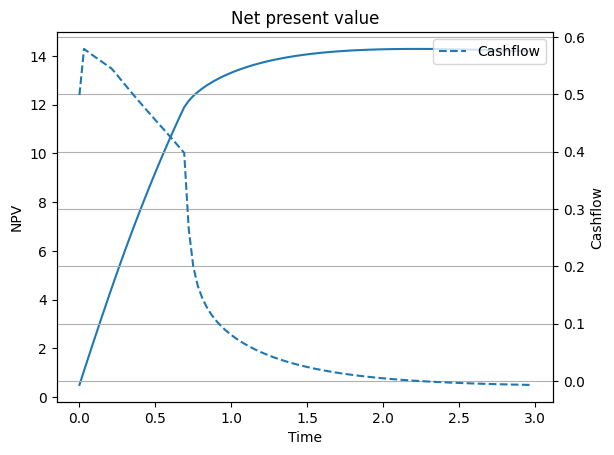

In [2]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from setup_bl import setup_bl_ocp, BLParamsMpc
from solver_ocp import SolverOcp

params_mpc = BLParamsMpc()
ocp = setup_bl_ocp(params_mpc)
solver = SolverOcp(ocp)


Sw0 = np.array([1.0]+[0.2]*(params_mpc.nx-1))  # initial state
qt = np.array([1.0]*params_mpc.N)  # initial guess for control

solver.set_initial_guess(Sw0, qt)
x_traj, u_traj = solver.solve(Sw0)

T = np.array(range(params_mpc.N+1))*params_mpc.dt

# plot control trajectory
plt.figure()
# plt.plot(T, u_traj.T)
plt.stairs(u_traj[0,:], T, label='u', baseline=None, orientation='vertical', linewidth=2)
plt.ylim(params_mpc.umin-0.03, params_mpc.umax+0.03)
plt.title('Optimal control trajectory')
plt.ylabel('Total water injection rate')
plt.xlabel('Time')
plt.grid(True)
plt.show()


# plot state trajectory
for k in range(x_traj.shape[1]):
    if k==0:
        plt.figure()
    elif k%10==0:
        plt.plot(range(params_mpc.nx), x_traj[:,k], label=f't={k*params_mpc.dt:.2f}')

plt.title('Optimal state trajectory')
plt.ylabel("Water saturation")
plt.xlabel("Grid block")
plt.grid(True)
plt.legend()
plt.show()

# plot the cost
cost_function = ca.Function('cost_function', [ocp.u, ocp.x], [ocp.stage_cost_expr])
ocp_cashflow = np.zeros(params_mpc.N)
npv = []
for k in range(params_mpc.N):
    if k==0:
        plt.figure()
    ocp_cashflow[k] = -cost_function(u_traj[0,k], x_traj[:,k])*0.99**(k)
    npv.append(ocp_cashflow[k] if k==0 else npv[-1] + ocp_cashflow[k])
        
plt.plot(T[:-1], npv, label='NPV')
plt.xlabel('Time')
plt.ylabel('NPV')
plt.title('Net present value')

# plot twin axis for cashflow
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.set_ylabel('Cashflow')
ax2.plot(T[:-1], ocp_cashflow, '--', label='Cashflow')

plt.legend()
plt.grid(True)
plt.show()

ocp_x_traj = x_traj*1
ocp_u_traj = u_traj*1

ocp_npv = npv*1


# Model Predictive Control with Moving Horizon

In [18]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from buckley_leverette import BuckleyLeverette
from setup_bl import setup_bl_ocp, BLParamsMpc
from solver_ocp import SolverOcp

# simulate MPC by applying the first control move and shifting
# bl = BuckleyLeverette()
params_mpc = BLParamsMpc()
n_mpc_steps = params_mpc.N*1

Sw0 = np.array([1.0]+[0.2]*(params_mpc.nx-1))  # initial state
qt = np.array([1.0]*params_mpc.N)  # initial guess for control
qt_sol = []
Sw_mpc = Sw0.copy()
qt_mpc = []
Sw_traj = [Sw_mpc.copy()]
cashflow = []
npv_mpc = [0.0]
for mpc_step in range(n_mpc_steps):
# for mpc_step in range(2):
    print(f'MPC step {mpc_step+1}/{n_mpc_steps}')

    # update stage constraint
    params_mpc.uinit = qt[0]

    # solve OCP
    ocp = setup_bl_ocp(params_mpc)
    solver = SolverOcp(ocp, itk=mpc_step)
    solver.set_initial_guess(Sw_mpc, qt)
    x_traj, u_traj = solver.solve(Sw_mpc)
    qt_sol.append(u_traj[0,0])
    
    # apply the first control move
    qt_mpc.append(u_traj[0,:])
    Sw_mpc = bl.simulate_at_k(Sw_mpc, u_traj[0,0])
    
    Sw_traj.append(Sw_mpc.copy())
    cashflow.append(-(cost_function(u_traj[0,0], Sw_mpc)*0.99**(mpc_step)).full()[0,0])
    npv_mpc.append((npv_mpc[-1] + cashflow[mpc_step]))
    
    # shift the control trajectory
    qt = np.hstack((u_traj[0,1:], u_traj[0,-1]))
    
Sw_traj = np.array(Sw_traj)
qt_mpc = np.array(qt_mpc).T

MPC step 1/100
MPC step 2/100
MPC step 3/100
MPC step 4/100
MPC step 5/100
MPC step 6/100
MPC step 7/100
MPC step 8/100
MPC step 9/100
MPC step 10/100
MPC step 11/100
MPC step 12/100
MPC step 13/100
MPC step 14/100
MPC step 15/100
MPC step 16/100
MPC step 17/100
MPC step 18/100
MPC step 19/100
MPC step 20/100
MPC step 21/100
MPC step 22/100
MPC step 23/100
MPC step 24/100
MPC step 25/100
MPC step 26/100
MPC step 27/100
MPC step 28/100
MPC step 29/100
MPC step 30/100
MPC step 31/100
MPC step 32/100
MPC step 33/100
MPC step 34/100
MPC step 35/100
MPC step 36/100
MPC step 37/100
MPC step 38/100
MPC step 39/100
MPC step 40/100
MPC step 41/100
MPC step 42/100
MPC step 43/100
MPC step 44/100
MPC step 45/100
MPC step 46/100
MPC step 47/100
MPC step 48/100
MPC step 49/100
MPC step 50/100
MPC step 51/100
MPC step 52/100
MPC step 53/100
MPC step 54/100
MPC step 55/100
MPC step 56/100
MPC step 57/100
MPC step 58/100
MPC step 59/100
MPC step 60/100
MPC step 61/100
MPC step 62/100
MPC step 63/100
M

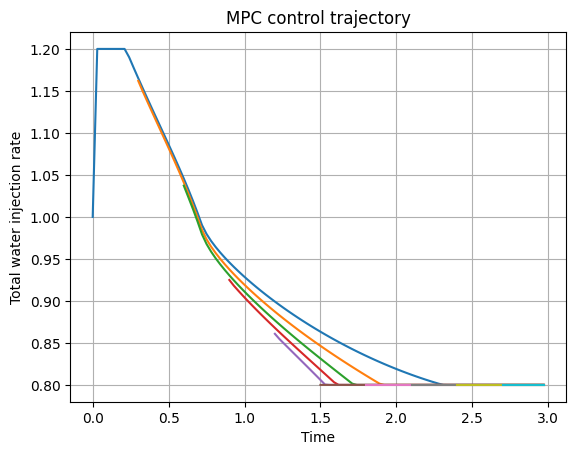

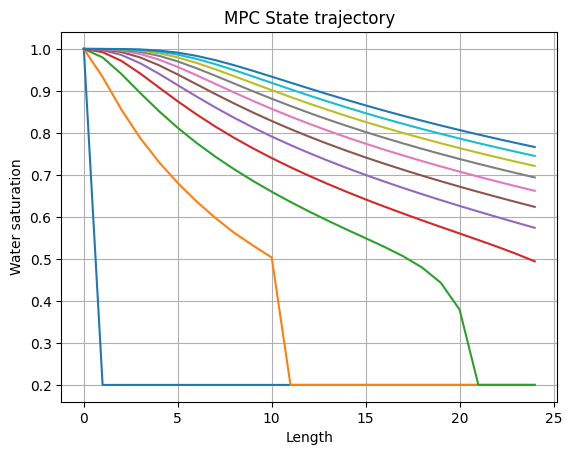

In [ ]:
plt.figure()
for i in range(qt_mpc.shape[1]):
    
    if i % 10 == 0:
        if i==0:
            T = np.arange(0, params_mpc.total_time, params_mpc.dt)
            plt.plot(T, qt_mpc[:,i], label=f'Step {i+1}')
        else:
            T = np.arange(0, params_mpc.total_time, params_mpc.dt)[i:]
            plt.plot(T, qt_mpc[:-(i),i], label=f'Step {i+1}')

plt.xlabel('Time')
plt.ylabel('Total water injection rate')
plt.title('MPC solutions control trajectory')
plt.grid(True)
# plt.legend()

plt.figure()
for i in range(Sw_traj.shape[0]):
    if i % 10 == 0:
        plt.plot(range(params_mpc.nx), Sw_traj[i,:], label=f'Step {i+1}')
plt.xlabel('Length')
plt.ylabel('Water saturation')
plt.title('MPC State trajectory')
plt.grid(True)

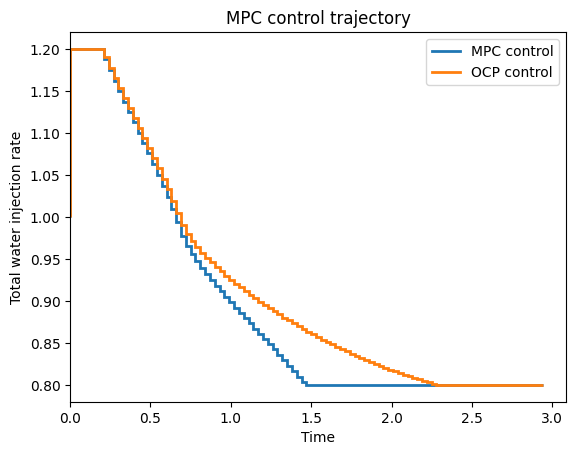

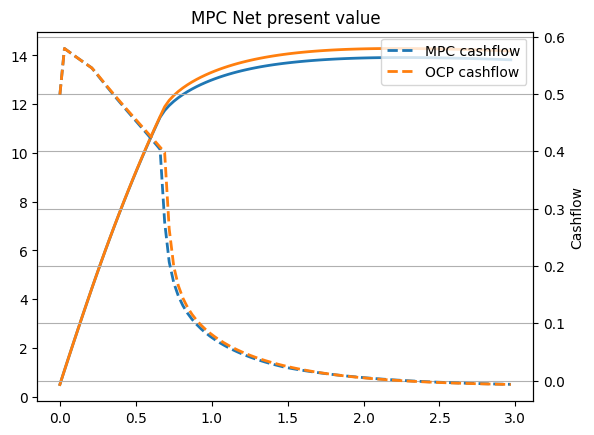

In [33]:
# plot control trajectory
plt.figure()
T = np.arange(0, params_mpc.total_time, params_mpc.dt)[:n_mpc_steps-1]
plt.stairs(T, qt_mpc[0,:], orientation='horizontal', label='MPC control', baseline=None, linewidth=2)
plt.stairs(T, ocp_u_traj[0,:], orientation='horizontal', label='OCP control', baseline=None, linewidth=2)
plt.legend()
plt.title('MPC control trajectory')
plt.ylabel('Total water injection rate')
plt.xlabel('Time')

# plot NPV trajectory
plt.figure()
T = np.arange(0, params_mpc.total_time, params_mpc.dt)
plt.plot(T, npv_mpc[1:], label='MPC NPV', linewidth=2)
plt.plot(T, ocp_npv, label='OCP NPV', linewidth=2)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.set_ylabel('Cashflow')
ax2.plot(T, cashflow, '--', label='MPC cashflow', linewidth=2)
ax2.plot(T, ocp_cashflow, '--', label='OCP cashflow', linewidth=2)
plt.xlabel('Time')
plt.ylabel('NPV')
plt.title('MPC Net present value')
ax2.set_ylabel('Cashflow')
plt.grid(True)
plt.legend()
plt.show()

# Run with MPC solutions (sanity check)

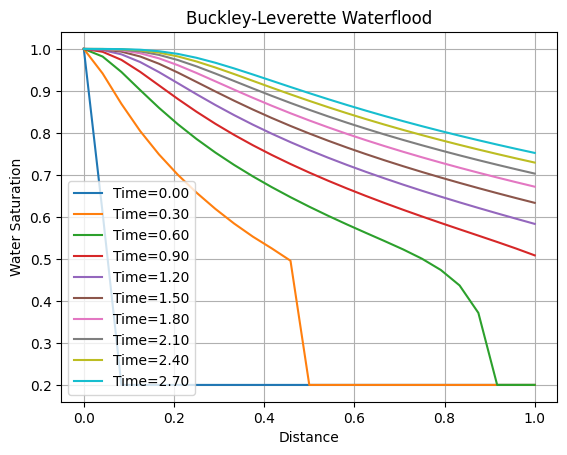

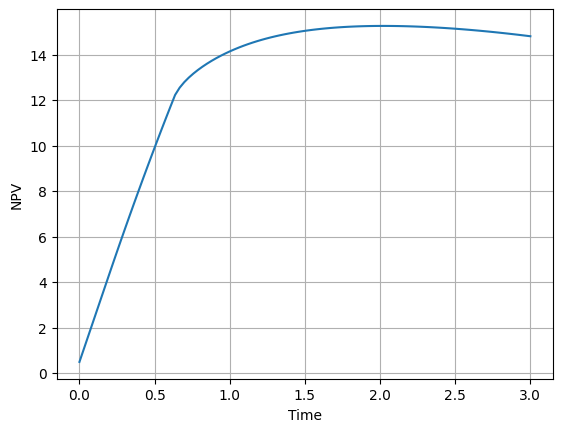

In [12]:
from buckley_leverette_ori import BuckleyLeverette 
import numpy as np

bl = BuckleyLeverette(nx=25, dt=0.03)


# qt = qt_sol
qt = qt_mpc[0,:]
Sw0 = np.array([1.0]+[0.2]*(bl.nx-1))  # initial state
bl.simulate_w_plot(Sw0, qt)
import matplotlib.pyplot as plt


npv = bl.cost_function(qt, Sw0)

plt.plot(bl.t, npv)
plt.xlabel('Time')
plt.ylabel('NPV')
plt.grid(True)
plt.show()

# bl.plot()
